<a href="https://colab.research.google.com/github/karhol/mock-portfolio/blob/main/Stroke_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stroke Prediction

introduction

Dataset: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

Import Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats
from scipy.stats import norm

from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, f1_score

import warnings
warnings.filterwarnings(action='ignore')

In [38]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


# Univariate Analysis of Categorical Variables

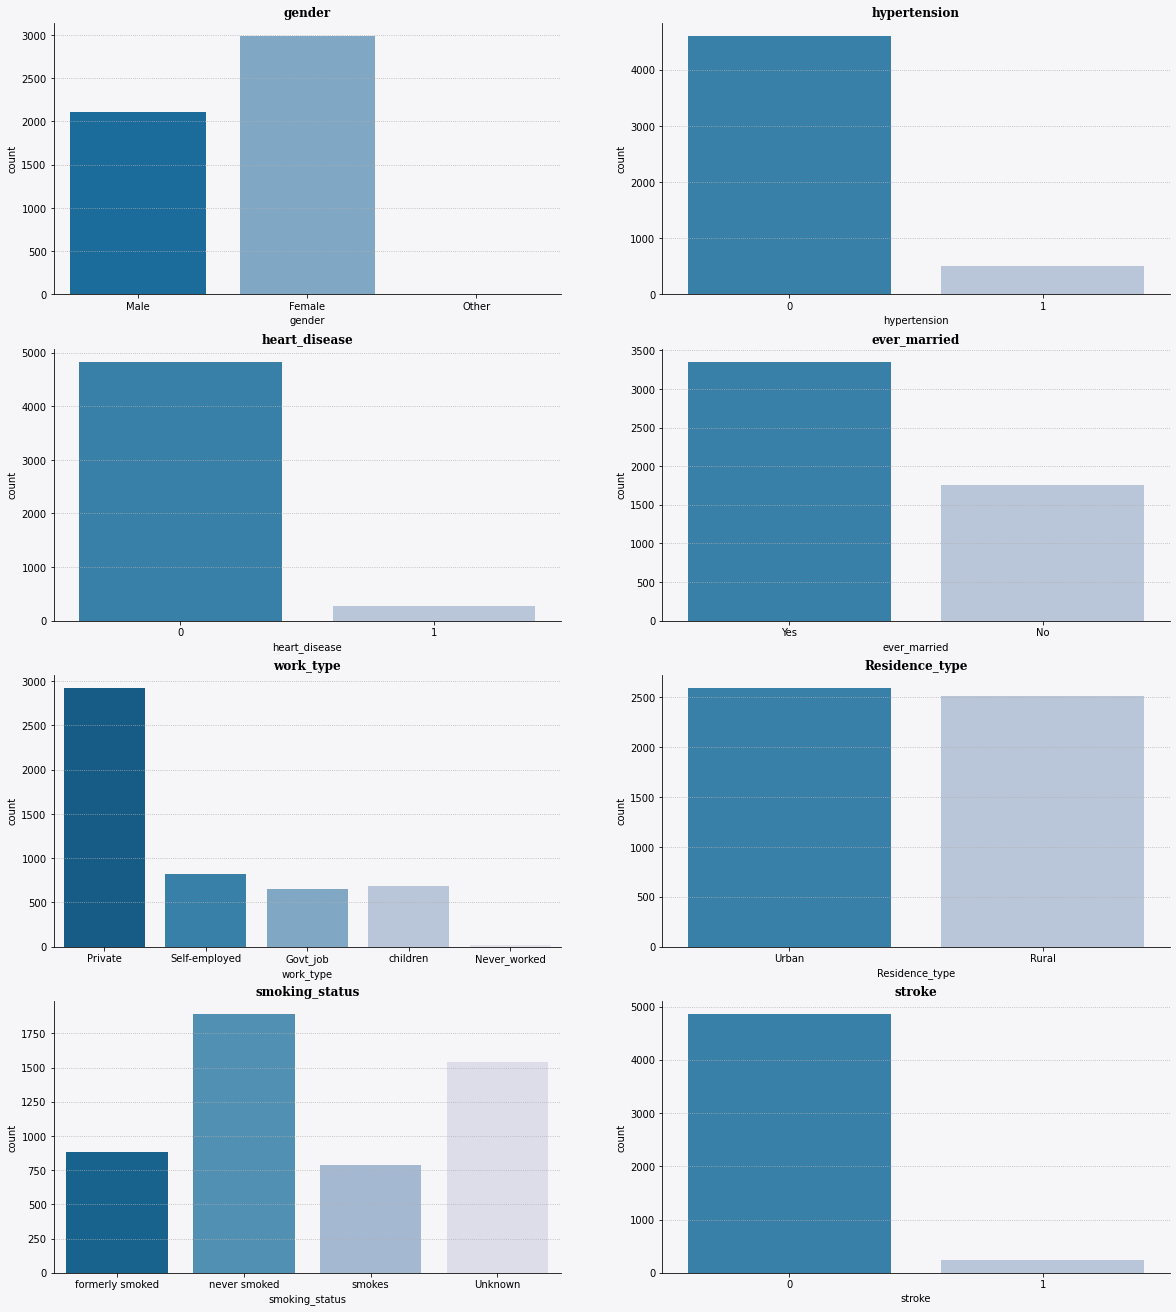

In [3]:
data_categorical=data[['gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 
                       'smoking_status', 'stroke']]

fig=plt.figure(figsize=(20,23))
background_color = '#f6f5f7'
fig.patch.set_facecolor(background_color) 
for indx,val in enumerate(data_categorical.columns):
    ax=plt.subplot(4,2,indx+1)
    ax.set_facecolor(background_color)
    ax.set_title(val,fontweight='bold',fontfamily='serif')
    for i in ['top','right']:
        ax.spines[i].set_visible(False)
    ax.grid(linestyle=':',axis='y')
    sns.countplot(data_categorical[val],palette='PuBu_r')

Observations :

1) The "Other" category in gender is not visible as it contains only one value. It might be best to drop it for better modeling

2) The number of people with hypertension is very low compared to those that don't have hypertension

3) The number of people with heart disease is very low compared to those that don't have heart disease

4) Number of people with strokes is very low compared to those that don't have strokes

Having so many unbalanced column is not ideal for good predictions

# Analysing Categorical Variables with Stroke

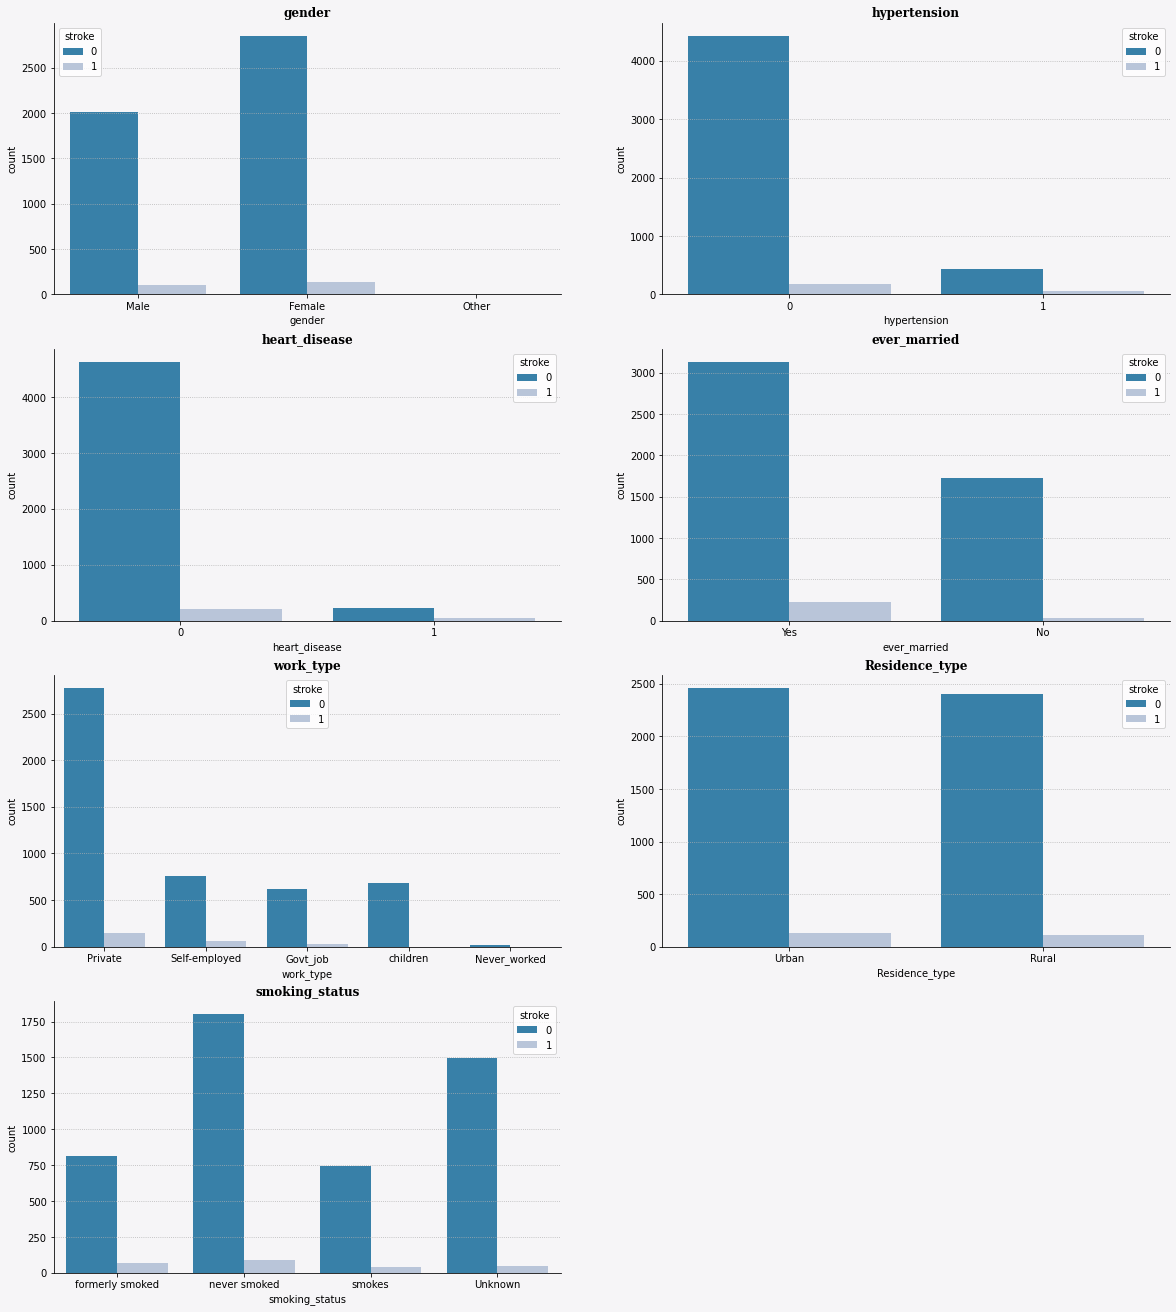

In [4]:
data_cat=data[['gender', 'hypertension', 'heart_disease', 'ever_married','work_type', 'Residence_type', 
                       'smoking_status']]
fig=plt.figure(figsize=(20,23))
background_color = '#f6f5f7'
fig.patch.set_facecolor(background_color) 
for indx,val in enumerate(data_cat.columns):
    ax=plt.subplot(4,2,indx+1)
    ax.set_facecolor(background_color)
    ax.set_title(val,fontweight='bold',fontfamily='serif')
    for i in ['top','right']:
        ax.spines[i].set_visible(False)
    ax.grid(linestyle=':',axis='y')
    sns.countplot(data_cat[val],palette='PuBu_r',hue=data['stroke'])

Observations 

1) The people with heart diesease show more signs of stroke 

2) The people who got married have way more strokes than people who are unmarried

3) The people living in urban and rural areas are almost identical when it comes to strokes

In this dataset there are very little amounts of strokes, this makes the graphs a bit hard to read 

Looking at the Percentages

In [7]:
print (f'A person with heart disease has a probability of {round(data[data["heart_disease"]==1]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person without heart disease has a probability of {round(data[data["heart_disease"]==0]["stroke"].mean()*100,2)} % get a stroke')

print("-"*20)

print()

print (f'A person with hypertension has a probability of {round(data[data["hypertension"]==1]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person without hypertension has a probability of  {round(data[data["hypertension"]==0]["stroke"].mean()*100,2)} % get a stroke')

print("-"*20)

print()

print (f'A person married (or married before) has a probability of {round(data[data["ever_married"]=="Yes"]["stroke"].mean()*100,2)} % get a stroke')

print()

print (f'A person never married has a probability of {round(data[data["ever_married"]=="No"]["stroke"].mean()*100,2)} % get a stroke')


A person with heart disease has a probability of 17.03 % get a stroke

A person without heart disease has a probability of 4.18 % get a stroke
--------------------

A person with hypertension has a probability of 13.25 % get a stroke

A person without hypertension has a probability of  3.97 % get a stroke
--------------------

A person married (or married before) has a probability of 6.56 % get a stroke

A person never married has a probability of 1.65 % get a stroke


A person with heart diease are **4.07 times** more likely to get stroke than the ones who don't have heart disease.

A person with hypertension are almost **3.3 times** more likely to get stroke than the ones who don't have hypertension

A person is married(or married before) are **5.7 times** more likely to get stroke than the ones who don't have marriage history

# Heat Map Correlation

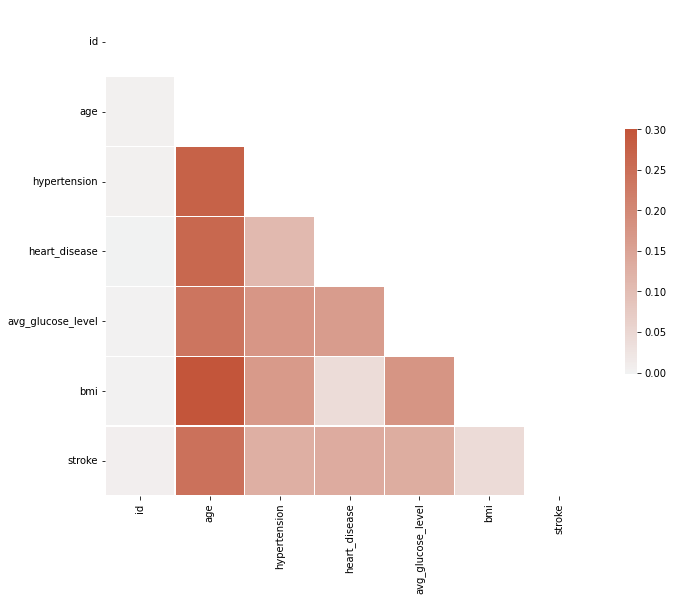

In [19]:
# Compute the correlation matrix
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

I like using this type of heatmap as it is just a little bit easier to read.

Looking at this correlation matrix it is obvious we will need to drop id as it has no connection with the target or other variables in the dataset.

Wierdly enough BMI has no correlation with heart diseas or stroke.
This sounds like an obvious inconsistency but the only way to prove this would be to double check with other datasets. 

# Inferno Visual 

In [9]:
import plotly.express as px
fig = px.parallel_categories(data[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type',
       'smoking_status', 'stroke']], color='stroke', color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

This is just a fun way to look at the data as you can get a birds view of what is going on. It helps me avoid getting trapped in my mind and truly look at the data.

# Preprocessing

In [39]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

def preprocessing(df):
    df = df.copy()
    
    # Drop id column, its useless 
    df = df.drop('id', axis=1)

    #drop the "other" in gender by using the index of that row
    df = df.drop(3116)
    
    # Binary encoding
    df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
    df['Residence_type'] = df['Residence_type'].replace({'Rural': 0, 'Urban': 1})
    
    # One-hot encoding
    for column in ['gender', 'work_type', 'smoking_status']:
        df = onehot_encode(df, column=column)

    #data['Age Groups']= pd.qcut(data['age'], q=4, labels=[0,1,2,3])
    
    # Split df into X and y
    y = df['stroke']
    X = df.drop('stroke', axis=1)
    
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    
    # KNN imputation
    imputer = KNNImputer()
    imputer.fit(X_train)
    X_train = pd.DataFrame(imputer.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    # Scaling X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test



In [40]:
X_train, X_test, y_train, y_test = preprocessing(data)

In [41]:
X_train.head(3)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,gender_Female,gender_Male,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
4314,0.073749,-0.328862,-0.236883,0.712899,0.997207,0.100035,0.262532,0.854916,-0.854916,-0.391378,-0.06704,-1.152443,2.328112,-0.397531,-0.669159,-0.454398,1.312834,-0.424038
376,-1.887958,-0.328862,-0.236883,-1.402724,-1.002800,-0.384229,-1.750838,0.854916,-0.854916,-0.391378,-0.06704,-1.152443,-0.429533,2.515526,1.494414,-0.454398,-0.761711,-0.424038
4913,-1.037826,-0.328862,-0.236883,-1.402724,0.997207,-0.463949,-1.097146,-1.169706,1.169706,-0.391378,-0.06704,0.867722,-0.429533,-0.397531,-0.669159,-0.454398,1.312834,-0.424038


# Handling Class Imbalance With Synthetic Minority Oversampling Technique

In [42]:
from imblearn.over_sampling import SMOTE
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE()
X_train_SMOTE, y_train_SMOTE = sm.fit_resample(X_train,y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train_SMOTE.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_SMOTE.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_SMOTE==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_SMOTE==0)))


Before OverSampling, counts of label '1': 166
Before OverSampling, counts of label '0': 3410 

After OverSampling, the shape of train_X: (6820, 18)
After OverSampling, the shape of train_y: (6820,) 

After OverSampling, counts of label '1': 3410
After OverSampling, counts of label '0': 3410


Training 

In [43]:
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                        Neural Network": MLPClassifier(),
    "                         Random Forest": RandomForestClassifier(),
    "                     Gradient Boosting": GradientBoostingClassifier(),
    "                               XGBoost": XGBClassifier(eval_metric='mlogloss'),
    "                              LightGBM": LGBMClassifier(),
    }

for name, model in models.items():
    model.fit(X_train_SMOTE, y_train_SMOTE)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                        Neural Network trained.
                         Random Forest trained.
                     Gradient Boosting trained.
                               XGBoost trained.
                              LightGBM trained.


Model Performance
-----------------

                   Logistic Regression Accuracy: 74.755%
				       F1-Score: 0.25434

                   K-Nearest Neighbors Accuracy: 83.431%
				       F1-Score: 0.13605

                         Decision Tree Accuracy: 86.301%
				       F1-Score: 0.13934

Support Vector Machine (Linear Kernel) Accuracy: 74.299%
				       F1-Score: 0.25660

   Support Vector Machine (RBF Kernel) Accuracy: 82.192%
				       F1-Score: 0.20408

                        Neural Network Accuracy: 87.606%
				       F1-Score: 0.11215

                         Random Forest Accuracy: 91.650%
				       F1-Score: 0.08571

                     Gradient Boosting Accuracy: 86.823%
				       F1-Score: 0.21094

                               XGBoost Accuracy: 85.910%
				       F1-Score: 0.23944

                              LightGBM Accuracy: 92.629%
				       F1-Score: 0.16296


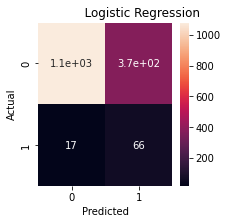

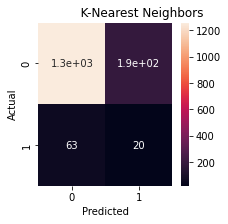

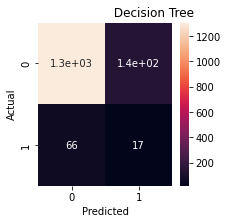

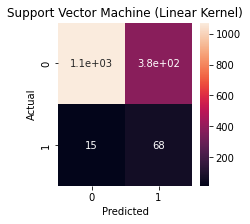

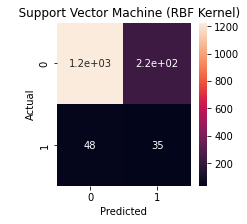

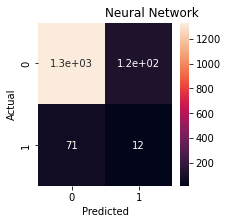

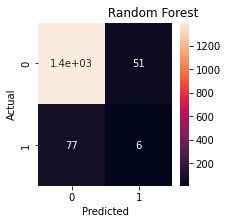

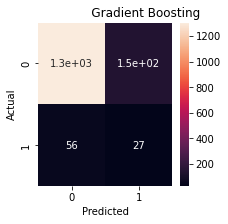

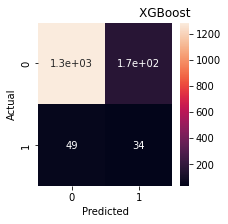

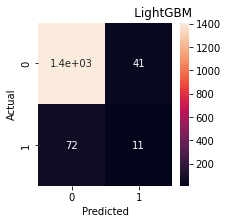

In [48]:
from sklearn.metrics import confusion_matrix

print("Model Performance\n-----------------")
for name, model in models.items():
    y_pred = model.predict(X_test)
    print(
        "\n" + name + " Accuracy: {:.3f}%\n\t\t\t\t       F1-Score: {:.5f}"\
        .format(accuracy_score(y_test, y_pred) * 100, f1_score(y_test, y_pred))
    )
    confusion_svc=confusion_matrix(y_test,model.predict(X_test))
    plt.figure(figsize=(3,3))
    sns.heatmap(confusion_svc,annot=True)
    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

NOTES

I had a really hard time when it came to choosing a model.
I looked at the implementation of others and when i thought they had great models, I would check the f1 score and it was abismal.

In the end i choose to follow
https://www.kaggle.com/code/gcdatkin/patient-stroke-prediction
just showing all the results for these basic models.

In the end because this is something medical we would like to make the safest predictions even if that doesnt mean getting the best predictons.
better be told you have cancer and not have it, than have cancer and be told you are healthy.

when the dataset isnt the best we cant get the best of results 

Refrences:

https://www.kaggle.com/code/casper6290/strokeprediction-99-acc

https://www.kaggle.com/subinium/simple-matplotlib-visualization-tips

https://www.kaggle.com/code/rachidyz/eda-and-modeling-for-predicting-stroke

https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79

https://www.kaggle.com/code/kaanboke/beginner-friendly-end-to-end-ml-project-enjoy

https://www.kaggle.com/subinium/simple-matplotlib-visualization-tips